# **Harris detector**

Implementation of the HARRIS’ detector algorithm.

* For each fixed pair of values of the algorithm parameters, the robustness of the implementation is measured with synthetic images of squares corrupted by increasing amounts of Gaussian noise.
* These values are plotted into three graphs against the standard deviation of the noise and compared with cv2.cornerHarris from [OpenCV](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html).

A [discussion](#discussion) considering the obtained results is conducted at the end of the notebook.

## **Implementation**

In [25]:
import math  
import cv2
import numpy as np
from matplotlib import pyplot as plt

def HarrisCornerDetector(img, blockSize, ksize, k):
    '''
        Harris Corner Detector implemenration using the gaussian filter for window summation
    '''

    lines, columns = img.shape

    neighbourhood = blockSize * 2 + 1

    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize) 

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # Summation using the gaussian filter to reduce noise influence
    Sx2 = cv2.GaussianBlur(Ix2, (neighbourhood ,neighbourhood ),0)
    Sy2 = cv2.GaussianBlur(Iy2, (neighbourhood ,neighbourhood ),0)
    Sxy = cv2.GaussianBlur(Ixy, (neighbourhood ,neighbourhood ),0)
    
    temp = np.zeros((2, 2))

    R = np.zeros((lines, columns))
        
    for x in range(lines):
        for y in range(columns):

            temp[0,0] = Sx2[x,y]
            temp[0,1] = Sxy[x,y]
            temp[1,0] = Sxy[x,y]
            temp[1,1] = Sy2[x,y]

            R[x,y] = np.linalg.det(temp) - k * (np.trace(temp)**2)

    return R

## **Auxiliary Functions**

In [26]:
def Limiarize(img, t):
    '''
        Limiarize the values on img to t value
    '''

    img_limiarized = img.copy()

    img_limiarized[img < t * img.max()] = 0.

    return img_limiarized


def NonmaxSuppression(img, N):
    '''
        Nonmax Suppression on img using a 2N + 1 sized window
    '''

    img_supressed = img.copy()
    lines, columns = img_supressed.shape

    for x in range(lines):
        for y in range(columns):

            if(img_supressed[x, y] > 0):
                value = img_supressed[x,y]

                for line in range(x - N, x + N + 1):
                    for column in range(y - N, y + N +1):
                        if((line >= 0 and line < lines) and (column  >= 0 and column < columns)):
                            if(img_supressed[line, column] < value):
                                img_supressed[line, column] = 0.

    return img_supressed


def CalculateCorners(start, end):
    '''
        Get all 4 corners for a square with its start and ending coordinates
    '''

    (x_start, y_start) = start
    (x_end, y_end) = end

    upper_left = (x_start + 1, y_start + 1)
    upper_right = (x_start + 1, y_end - 1)
    bottom_left = (x_end - 1, y_start + 1)
    bottom_right = (x_end - 1, y_end - 1)

    return upper_left, upper_right, bottom_left, bottom_right


def GenerateSquares(num_squares, side, gap, color):
    '''
        Generates a blank image containing num_squares with side size and within a gap distance from each other
    '''

    dim = num_squares * (side + gap) + gap
    img_squares = np.ones((dim, dim, 3))
    img_squares = np.uint8(img_squares * 255)

    list_corners = []

    p1_x = 0
    p1_y = 0
    p2_x = 0
    p2_y = 0 

    for i in range(1, num_squares + 1):
        for j in range(1, num_squares + 1):
        
            p1_x = i * gap + (i-1) * side
            p1_y = j * gap + (j-1) * side

            p2_x = p1_x + side
            p2_y = p1_y + side

            point_start = (p1_x, p1_y)
            point_end = (p2_x , p2_y)

            img_squares = cv2.rectangle(img_squares, point_start, point_end, color, -1)

            c1, c2, c3, c4 = CalculateCorners(point_start, point_end)

            list_corners.append(c1)
            list_corners.append(c2)
            list_corners.append(c3)
            list_corners.append(c4)

    return img_squares, list_corners


def DrawCorners(img, corners, radius, thickness, color):
    '''
        Draw the coner points involved by a circle for better visualization
    '''

    img_drawn = img.copy()

    for corner in corners:
        (x, y) = corner
        img_drawn[x, y] = color

        img_drawn = cv2.circle(img_drawn, (y,x), radius, color, thickness)

    return img_drawn


def AddNoise(img, std):
    '''
        Add noise to img with mean equals zero and std standard deviation
    '''

    gaussian_noise = np.zeros(img.shape, dtype=np.int8)

    cv2.randn(gaussian_noise, 0, std)
    
    img_noisy = img + gaussian_noise

    img_noisy = np.uint8(np.clip(img_noisy, 0, 255))

    return img_noisy


def GetCorners(mat):
    '''
        Get the corner points for a R matrix
    '''

    lines, columns = mat.shape

    list_corners = []

    for x in range(lines):
        for y in range(columns):
            if(mat[x,y] > 0):
                corner = (x,y)
                list_corners.append(corner)

    return list_corners


def RobustnessTest(predictions, targets):
    '''
        Robustness test recieving a list of prediction and target points, and returning the
        RMS distance and the amount of spurious and missed points
    '''

    num_points = len(targets)
    dist_total = 0.
    missed = 0

    # For each point in targets, get the closest point in predictions
    for target in targets:
        
        lowest_dist = float('inf')
        point = None

        for prediction in predictions:

            sum_square = float(((prediction[0] - target[0]) ** 2) + ((prediction[1] - target[1]) ** 2))
            actual_dist = math.sqrt(sum_square/2.)

            if(actual_dist < lowest_dist):
                lowest_dist = actual_dist
                point = prediction
                
        if(point):
            predictions.remove(point)
            dist_total += lowest_dist

        else:
            missed +=1

    spurious = len(predictions)
    dist_avg = dist_total/float(num_points)

    return dist_avg, missed, spurious


def PlotGraphs(title, num_tests, std, results):
    '''
        Generates the graphs using the information obtained from the robustness test
    '''
    
    fig = plt.figure()
    fig.suptitle(title, fontsize=20, weight='bold')
    fig.set_size_inches(18.5, 10.5)
    labels = ['RMSD', 'Missed', 'Spurious']

    for graph in range(3):

        ax = fig.add_subplot(3, 1, graph+1)

        ind = np.arange(num_tests + 1)
        width = 0.3 

        # The bars
        rects1 = ax.bar(ind, results[graph][0], width, color='blue')
        rects2 = ax.bar(ind + width, results[graph][1], width, color='red')

        # Axes and labels
        ax.set_xlim(-width, len(ind) + width)
        ax.set_ylabel(labels[graph], weight='bold')
        ax.set_xlabel('Noise', weight='bold')
        xTickMarks = [str(i * std) for i in range(num_tests + 1)]
        ax.set_xticks(ind + width/ 2)
        xtickNames = ax.set_xticklabels(xTickMarks)
        plt.setp(xtickNames, rotation='horizontal', fontsize=10)

        ax.legend((rects1[0], rects2[0]), ('Implemented', 'OpenCV'))

    plt.show()

## **Pipelines**

In [27]:
def TestPipeline(imgs, blockSize, ksize, k, t):
    '''
        Initial text pipelining checking the outputs for each step of my implementation compared to the opencv.
        Next we compare the obtained corners from diverse image types.
    '''     

    print('>>  Algorithm parameters')
    print('>>    Window Size:',blockSize)
    print('>>    Sobel Aperture:',ksize)
    print('>>    Lambda:',k)
    print('>>    Threshold:',t)

    img_squares, corners_true = GenerateSquares(4, 50, 50, (0,0,0))
    img_squares_gray = cv2.cvtColor(img_squares, cv2.COLOR_RGB2GRAY)

    # Steps Example
    print('>>  Steps comparison...')

    implementation_corners = HarrisCornerDetector(img_squares_gray, blockSize, ksize, k)
    implementation_corners_limiarized = Limiarize(implementation_corners, t)
    implementation_corners_supressed = NonmaxSuppression(implementation_corners_limiarized, blockSize)

    opencv_corners = cv2.cornerHarris(img_squares_gray, blockSize, ksize, k)
    opencv_corners_limiarized = Limiarize(opencv_corners, t)
    opencv_corners_supressed = NonmaxSuppression(opencv_corners_limiarized, blockSize)

    plt.suptitle('Implementation vs. OpenCV', fontsize=20, weight='bold')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.subplot(4,2,1)
    plt.imshow(img_squares)
    plt.title('Original')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,2)
    plt.imshow(img_squares)
    plt.title('Original')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,3)
    plt.imshow(implementation_corners)
    plt.title('R')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,4)
    plt.imshow(opencv_corners)
    plt.title('R')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,5)
    plt.imshow(implementation_corners_limiarized)
    plt.title('Limiarized')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,6)
    plt.imshow(opencv_corners_limiarized)
    plt.title('Limiarized')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,7)
    plt.imshow(implementation_corners_supressed)
    plt.title('Supressed')
    plt.xticks([]), plt.yticks([])

    plt.subplot(4,2,8)
    plt.imshow(opencv_corners_supressed)
    plt.title('Supressed')
    plt.xticks([]), plt.yticks([])
    plt.show()

    radius = blockSize
    thickness = 2
    color = (255, 0, 0)

    plt.suptitle('Implementation vs. OpenCV', fontsize=20, weight='bold')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    
    # Coners Examples
    print('>>  Processing example images...')

    for i, img in enumerate(imgs): 

        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        implementation_corners = HarrisCornerDetector(img_gray, blockSize, ksize, k)
        implementation_corners_limiarized = Limiarize(implementation_corners, t)
        implementation_corners_supressed = NonmaxSuppression(implementation_corners_limiarized, blockSize)
        implementation_corners_predicted = GetCorners(implementation_corners_supressed)

        opencv_corners = cv2.cornerHarris(img_gray, blockSize, ksize, k)
        opencv_corners_limiarized = Limiarize(opencv_corners, t)
        opencv_corners_supressed = NonmaxSuppression(opencv_corners_limiarized, blockSize)
        opencv_corners_predicted = GetCorners(opencv_corners_supressed)

        implementation_img = img.copy()
        implementation_img = DrawCorners(implementation_img, implementation_corners_predicted, radius, thickness, color)

        opencv_img = img.copy()
        opencv_img = DrawCorners(opencv_img, opencv_corners_predicted, radius, thickness, color)

        plt.subplot(len(imgs), 2, 1 + (2 * i))
        plt.imshow(implementation_img)
        plt.xticks([]), plt.yticks([])

        plt.subplot(len(imgs), 2, 2 + (2 * i))
        plt.imshow(opencv_img)
        plt.xticks([]), plt.yticks([])

    plt.show()
        

def ComparisontPipeline(num_squares, side, gap, color, blockSize, ksize, k, t, std, num_tests):       
    '''
        Pipeline for the comparison of the results from the robustness tests for my implementation and
        the OpenCV detector
    '''

    print('>>  Algorithm parameters')
    print('>>    Square Side:',side)
    print('>>    Window Size:',blockSize)
    print('>>    Sobel Aperture:',ksize)
    print('>>    Lambda:',k)
    print('>>    Threshold:',t)

    img_squares, corners_true = GenerateSquares(num_squares, side, gap, color)
    img_squares_gray = cv2.cvtColor(img_squares, cv2.COLOR_RGB2GRAY)

    imgs_noisy = []
    
    # Generating nosy images
    print('>>  Generating synthetic images...')

    plt.suptitle('Generated Synthetic Images', fontsize=20, weight='bold')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    
    for test in range(num_tests+1):
        img_noisy =  AddNoise(img_squares_gray, std * test)
        imgs_noisy.append(img_noisy)   
        plt.subplot(2, (num_tests + 1)/ 2, test + 1)
        plt.imshow(img_noisy)
        plt.title('Noise: ' + str(std * test))
        plt.xticks([]), plt.yticks([])

    plt.show()

    my_distances = []
    my_missed_points = []
    my_spurious_points = []

    opencv_distances = []
    opencv_missed_points = []
    opencv_spurious_points = []

    print('>>  Processing images...')
    
    for i, image in enumerate(imgs_noisy):

        print('>>   ' + str(i+1) + '...')
        
        my_corners = HarrisCornerDetector(image, blockSize, ksize, k)
        my_corners_limiarized = Limiarize(my_corners, t)
        my_corners_supressed = NonmaxSuppression(my_corners_limiarized, blockSize)
        my_corners_predicted = GetCorners(my_corners_supressed)

        opencv_corners = cv2.cornerHarris(image, blockSize * 2 + 1, ksize, k)
        opencv_corners_limiarized = Limiarize(opencv_corners, t)
        opencv_corners_supressed = NonmaxSuppression(opencv_corners_limiarized, blockSize)
        opencv_corners_predicted = GetCorners(opencv_corners_supressed) 

        my_distance, my_missed, my_spurious = RobustnessTest(my_corners_predicted, corners_true)

        my_distances.append(my_distance)
        my_missed_points.append(my_missed)
        my_spurious_points.append(my_spurious)

        opencv_distance, opencv_missed, opencv_spurious = RobustnessTest(opencv_corners_predicted, corners_true)

        opencv_distances.append(opencv_distance)
        opencv_missed_points.append(opencv_missed)
        opencv_spurious_points.append(opencv_spurious)

    return [[my_distances, opencv_distances],[my_missed_points, opencv_missed_points],[my_spurious_points, opencv_spurious_points]]

## **Initial Test**

Showing results by step and testing on arbitrary images:

>> Starting Test Pipeline...
>>  Algorithm parameters
>>    Window Size: 2
>>    Sobel Aperture: 15
>>    Lambda: 0.04
>>    Threshold: 0.01
>>  Steps comparison...


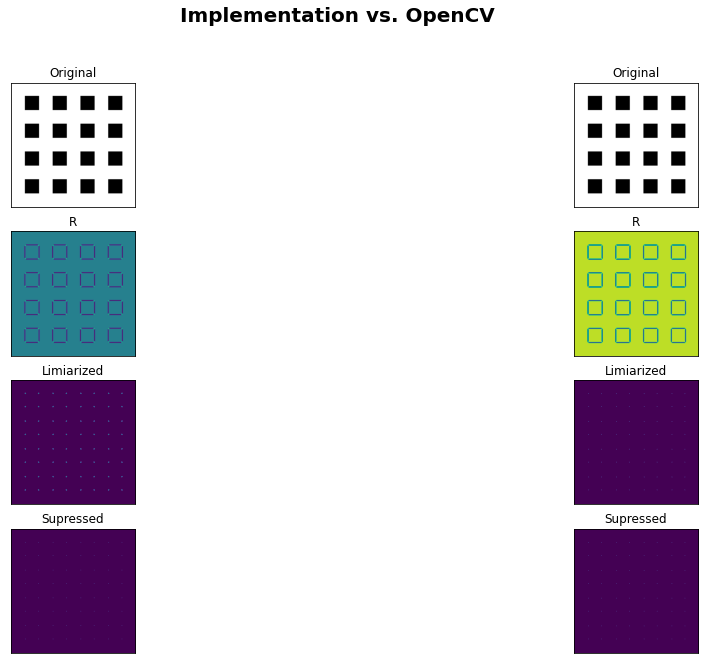

>>  Processing example images...


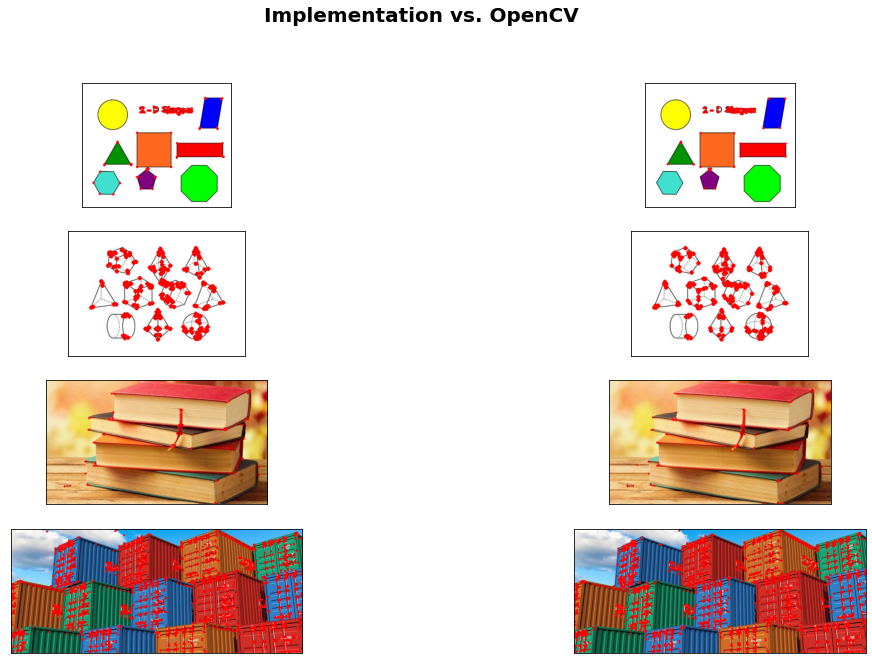

>> ...done!


In [28]:
# Test
print('>> Starting Test Pipeline...')

# Coner Detector Parameters
blockSize = 2           # Window size for Harris Corner Detector
ksize = 15               # Aperture parameter of Sobel derivative
k = 0.04                # Free parameter for Harris Corner Detector 
t = 0.01                # Threshold for R
num_imgs = 4

imgs_test = []

for i in range(1,num_imgs+1):
    img = cv2.cvtColor(cv2.imread('img' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
    imgs_test.append(img)

TestPipeline(imgs_test, blockSize, ksize, k, t)

print('>> ...done!')

## **Small Window**

Testing on small neighborhood and kernel size versus big squares synthetic images:

>> Starting Comparison Pipeline...
>>  Window size smaller than square side
>>  Algorithm parameters
>>    Square Side: 30
>>    Window Size: 6
>>    Sobel Aperture: 3
>>    Lambda: 0.04
>>    Threshold: 0.01
>>  Generating synthetic images...


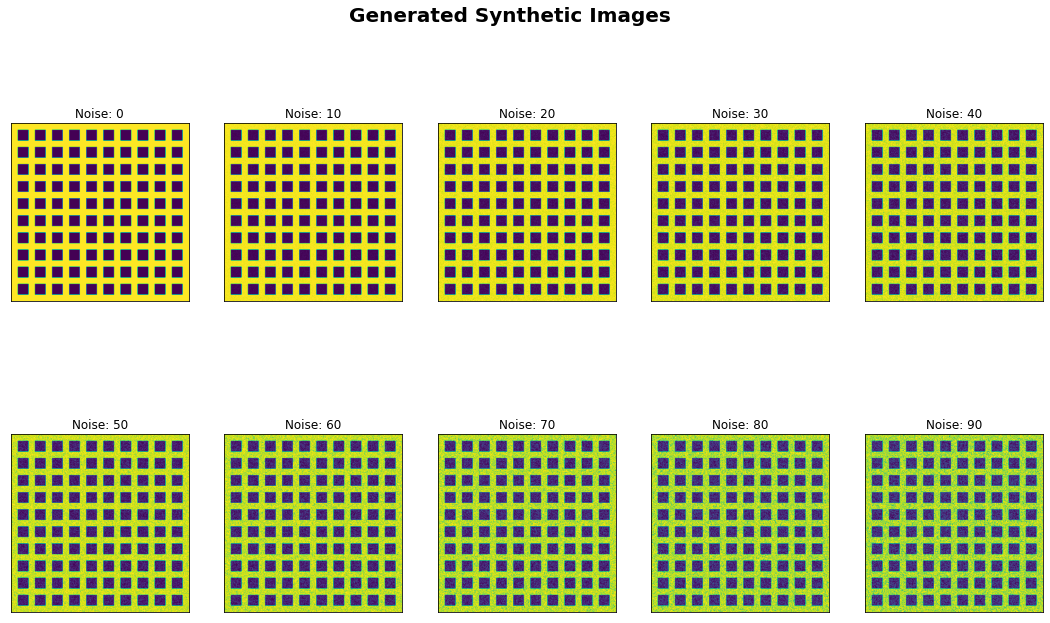

>>  Processing images...
>>   1...
>>   2...
>>   3...
>>   4...
>>   5...
>>   6...
>>   7...
>>   8...
>>   9...
>>   10...


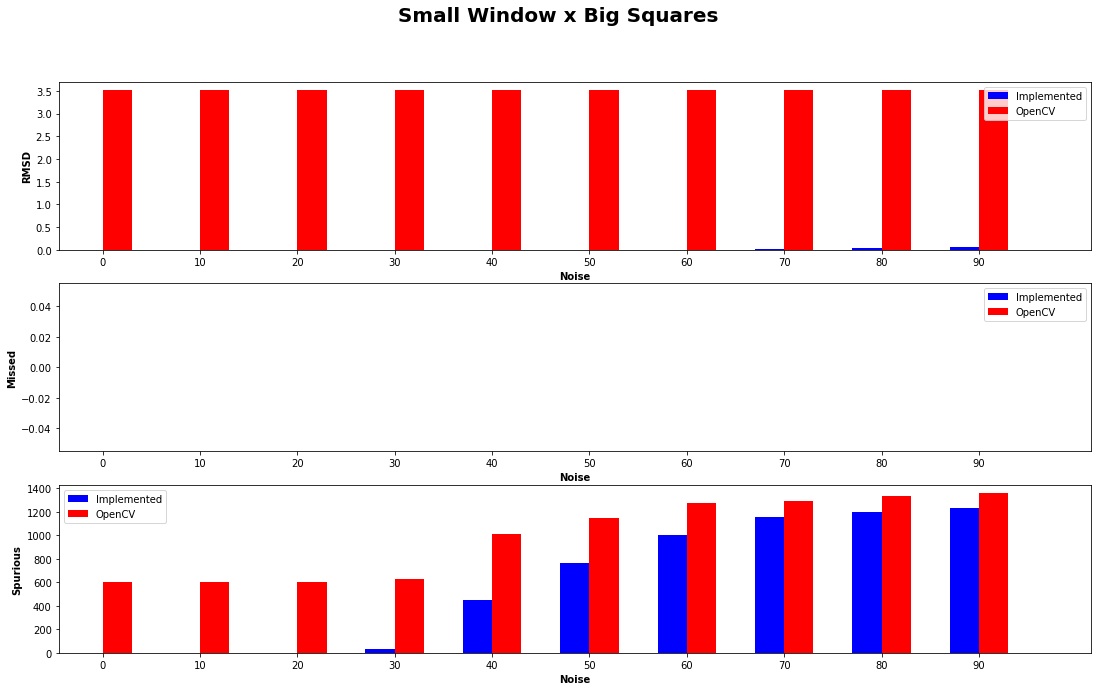

>>  ...done!


In [29]:
# Small Window x Big Squares
print('>> Starting Comparison Pipeline...')
print('>>  Window size smaller than square side')

# Square Generator Parameters
num_squares = 10
side = 30
gap = 20
color = (0,0,0)

# Coner Detector Parameters  
blockSize = 6           # Window size for Harris Corner Detector
ksize = 3               # Aperture parameter of Sobel derivative
k = 0.04                # Free parameter for Harris Corner Detector 
t = 0.01                # Threshold for R

# Noise
std = 10
num_tests = 9

results = ComparisontPipeline(num_squares, side, gap, color, blockSize, ksize, k, t, std, num_tests)
PlotGraphs('Small Window x Big Squares', num_tests, std, results)

print('>>  ...done!')


## **Big Window**

Testing on big neighborhood and kernel size versus small squares synthetic images:

>>  Window size bigger than square side
>>  Algorithm parameters
>>    Square Side: 2
>>    Window Size: 6
>>    Sobel Aperture: 3
>>    Lambda: 0.04
>>    Threshold: 0.01
>>  Generating synthetic images...


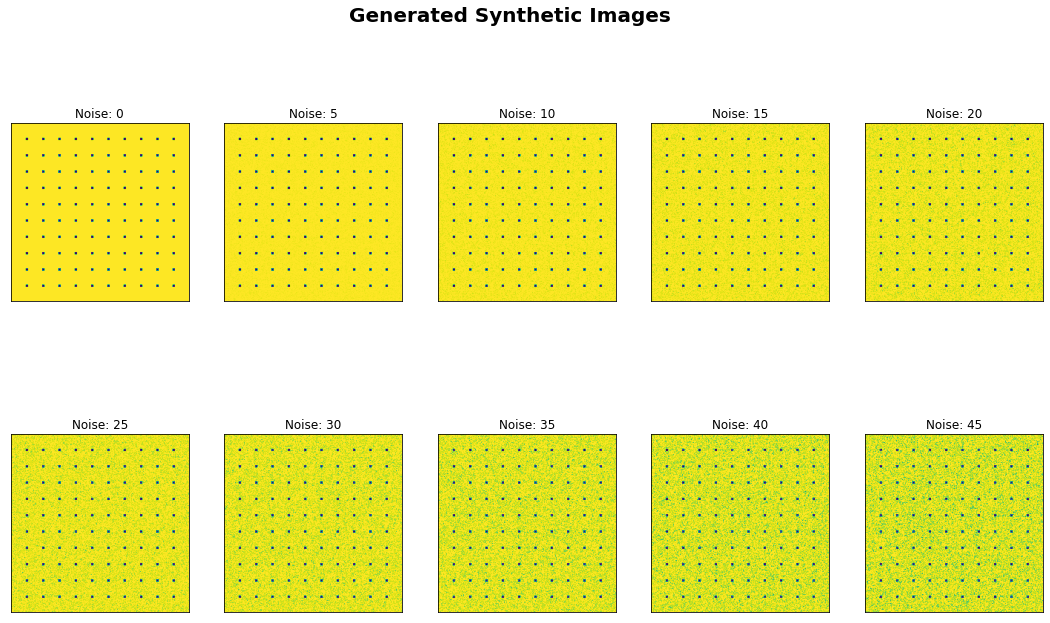

>>  Processing images...
>>   1...
>>   2...
>>   3...
>>   4...
>>   5...
>>   6...
>>   7...
>>   8...
>>   9...
>>   10...


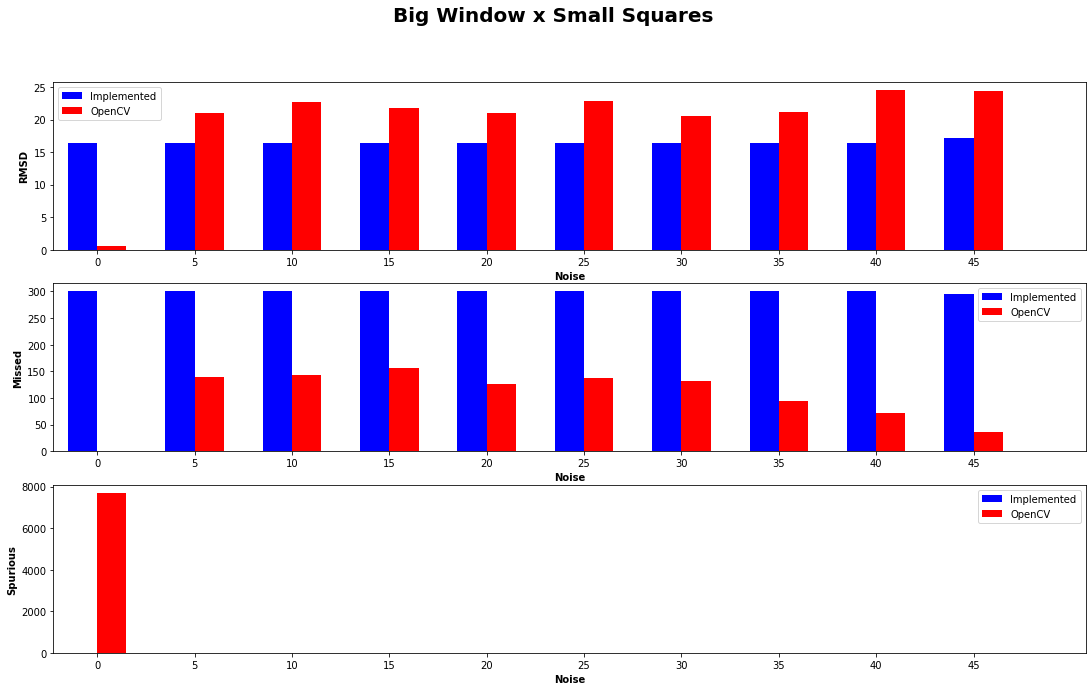

>>  ...done!
>> Tests Finalized


In [30]:
# Big Window x Small Squares
print('>>  Window size bigger than square side')

# Square Generator Parameters
num_squares = 10
side = 2
gap = 20
color = (0,0,0)

# Coner Detector Parameters
blockSize = 6           # Window size for Harris Corner Detector
ksize = 3               # Aperture parameter of Sobel derivative
k = 0.04                # Free parameter for Harris Corner Detector 
t = 0.01                # Threshold for R

# Noise
std = 5
num_tests = 9

results = ComparisontPipeline(num_squares, side, gap, color, blockSize, ksize, k, t, std, num_tests)
PlotGraphs('Big Window x Small Squares', num_tests, std, results)

print('>>  ...done!')

print('>> Tests Finalized')

## **Discussion**

The relationships between each parameter of the method and even image characteristics such as size and forms can heavily influence the results, this is specially true for the neighborhood and the squares sizes. When the first is smaller, we are able to identify all the corners, but we also start to generate spurious ones with the increasing noise. However, if the neighborhood is smaller than the sides, the algorithm misses a lot of corners.

There are also interactions between the size of the Sobel filter and the neighborhood size, which are responsible for "moving" the detected corners localization. Finally, the lambda and the threshold can add another layer of complexity to the problem, since they are directly responsible for providing more corner candidates, what can drastically chance the method outcome.

The difference between the implemented method and the OpenCV is basically because of the use of the Gaussian filter instead of a simple summation. This modification made the method much more robust to noise, as we can see in the graphs, especially in the first case, where the distance is slightly affected by the noise, and the number of spurious corners only catches up with the original implementation with really high amounts of noise.

With this information, we can conclude that the adequate parameters have to be obtained empirically, depending on the size of the target image and the sizes and types of forms contained in it.